In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import multibind as mb
import numpy as np
import pandas as pd
import torch
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = '/mnt/c/Users/ignacio.ibarra/Dropbox/annotations'
# mb.models.MultiBind
import torch.optim as topti
import torch.utils.data as tdata
import matplotlib.pyplot as plt
import logomaker

# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

/home/rio/miniconda3/envs/multibind/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda:0


In [3]:
data = bd.bindome.datasets.SELEX.get_data()
# data[data['cycle'] == 'AF']
data

cardiac_complexes
# filenames 22
PRJEB14744
# filenames 12
PRJEB20112
# filenames 46
PRJEB3289
# filenames 68
PRJEB9797
# filenames 184


,filename,library,batch,cycle,tf.name,accession
0,GATA4TBX5_R1_R46_016_999.txt.gz,R46,R46,R46,GATA4TBX5,cardiac_complexes
1,GATA4TBX5_R2_R46_033_999.txt.gz,R46,R46,R46,GATA4TBX5,cardiac_complexes
2,GATA4TBX5_R3_R46_051_999.txt.gz,R46,R46,R46,GATA4TBX5,cardiac_complexes
3,GATA4_R1_R46_032_777.txt.gz,R46,R46,R46,GATA4,cardiac_complexes
4,GATA4_R2_R46_046_777.txt.gz,R46,R46,R46,GATA4,cardiac_complexes
...,...,...,...,...,...,...
327,FOXA1_FL_2_KX_TCCCAT40NTGT.fastq.gz,TCCCAT40NTGT,FL,2,FOXA1,PRJEB9797
328,FOXA1_FL_3_KX_TAGCGT40NTCA.fastq.gz,TAGCGT40NTCA,FL,3,FOXA1,PRJEB9797
329,FOXA1_FL_3_KX_TCCCAT40NTGT.fastq.gz,TCCCAT40NTGT,FL,3,FOXA1,PRJEB9797
330,FOXA1_FL_4_KX_TAGCGT40NTCA.fastq.gz,TAGCGT40NTCA,FL,4,FOXA1,PRJEB9797


In [4]:
set(data['tf.name'])

{'ALX1',
 'ALX4',
 'EGR1',
 'ELF2',
 'ELF3',
 'ELF4',
 'ELK1',
 'ELK3',
 'ETS1',
 'ETV4',
 'ETV5',
 'ETV6',
 'FOXA1',
 'GATA4',
 'GATA4TBX5',
 'NKX2-5',
 'NKX2-5GATA4',
 'NKX2-5TBX5',
 'R46',
 'SAMPLE',
 'TBX5',
 'ZEROCYCLE'}

### Custom optimization pipeline: one layer is flexible and the others are frozen.

Only one unfrozen layer, test with ALX4

In [5]:
# %time np.array([mb.tl.onehot_mononuc(row['seq'], le, oe) for index, row in next_data.head(10000).iterrows()]).shape

In [6]:
# %time next_data.head(10000)['seq'].apply(mb.tl.onehot_mononuc, args=(le, oe)) # (row['seq'], le, oe) for index, row in next_data.head(10).iterrows()])

In [12]:
# update main object to skip reading again in future iterations
def update_dict(d1, d2):
    for k in list(d2.keys()):
        if not k in d1:
            d1[k] = d2[k]
        else:
            d2[k] = d1[k]


In [ ]:
reads_tf = {}
reads_tf_zero = {}

ALX4
ALX4 TGTGTC20NGA
12 2
dict_keys(['ALX4_TGTGTC20NGA_W_1', 'ALX4_TGTGTC20NGA_W_2', 'ALX4_TGTGTC20NGA_W_3', 'ALX4_TGTGTC20NGA_W_4']) dict_keys(['ZeroCycle_ES0_TGTGTC20NGA_0', 'ZeroCycle_TGTGTC20NGA_0_0'])
4
sampling from top n reds in round 1 ...
(920358, 12)
(10000, 12)
loading object (# entries) 10000
next w 14
kernel to optimize 0
Epoch:  1, Loss: 23.621
Epoch: 11, Loss: 23.591
Epoch: 21, Loss: 23.662
before shift optim.


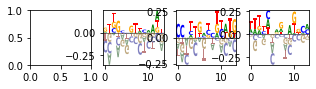

after shift optimz model


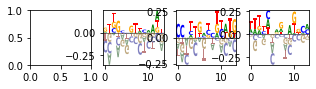


kernel to optimize 1
Epoch:  1, Loss: 23.601
Epoch: 11, Loss: 23.591
Epoch: 21, Loss: 23.642
before shift optim.


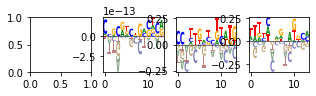

optimize_motif_shift (once)...23.54033546447754 23.57069182395935 23.580810403823854
after shift optimz model


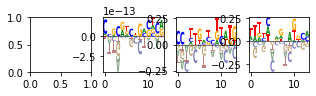


kernel to optimize 2
Epoch:  1, Loss: 23.611
Epoch: 11, Loss: 23.601
Epoch: 21, Loss: 23.631
before shift optim.


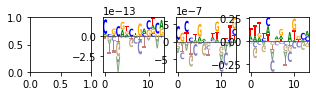

optimize_motif_shift (once)...23.55045437812805 23.550453996658327 23.560572957992555
optimize_motif_shift (again)...

In [ ]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 5, 1

model_by_k = {}
for tf in set(data['tf.name']):
    if 'ZERO' in tf:
        continue
    if tf != 'ALX4':
        continue
    print(tf)
    
    
    for library, grp in data.groupby('library'):
        
        if library != 'TGTGTC20NGA':
            continue
        
        print(tf, library)
        
        reads_tf_next, reads_zero_next = mb.bindome.datasets.SELEX.load_tf_and_zero_reads(tf, data, library=library,
                                                                                          k_skip=reads_tf.keys())
        
        # update main object to skip reading again in future iterations
        update_dict(reads_tf, reads_tf_next)
        update_dict(reads_zero, reads_zero_next)
        
        
        print(reads_tf.keys(), reads_zero.keys())
        
        for k_r0 in reads_zero:

            k_model = tf + ':' + k_r0
            # print(k_r0, k_tf, k_model)

            n_rounds = len(reads_tf.keys())
            print(n_rounds)
            
            # combine all the positive round data
            df2 = []
            for k in reads_tf.keys():
                df = reads_tf[k]
                df['k'] = k
                df2.append(df)
            df = pd.concat(df2)
            df = df.pivot('seq', 'k', 'counts').fillna(0).reset_index()

            next_data = reads_zero[k_r0].merge(df, on='seq', how='outer').fillna(0) # .astype(int)
            
            new_cols = ['seq', k_r0] + list(df.columns[1:])
            next_data.columns = new_cols
            for i, k in enumerate(next_data.columns[1:]):
                next_data[k] = next_data[k].astype(int)
                next_data[i] = next_data[k].astype(int)

                
            next_data['sum'] = next_data[[i for i in range(0, n_rounds + 1)]].sum(axis=1).values
            next_data = next_data.sort_values('sum', ascending=False)
            
            print('sampling from top n reds in round 1 ...')
            print(next_data.shape)
            next_data = next_data.head(10000).reset_index(drop=True)
            print(next_data.shape)
            
            # assert False
            
            # next_data = next_data.sample(n=35000)

            # print(next_data.shape)
            # print(next_data.head())

            # not needed for the current model, because the enrichment is not predicted
            # next_data = mb.tl.calculate_enrichment(next_data, cols=next_data.columns[1:])

            # assign batch and data type
            next_data['batch'] = 1
            next_data['is_count_data'] = 1

            print('loading object (# entries)', next_data.shape[0])
            dataset = mb.datasets.SelexDataset(next_data, n_rounds=n_rounds)
            train = tdata.DataLoader(dataset=dataset, batch_size=256, shuffle=True)
            train_test = tdata.DataLoader(dataset=dataset, batch_size=1, shuffle=False)                

            model_by_k_next, res_next = mb.tl.train_iterative(train, device, min_w=10, max_w=15, n_rounds=n_rounds)                
            res = []
            model_by_k = {}

            assert False
                
                # stop (debugging)
                